# **APRENDIZAJE POR REFUERZO - Q-LEARNING**

## Exploración vs Explotación

La principal diferencia entre el axr y el resto de métodos de aprendizaje es que durante el entrenamiento un agente aprende a través de la evaluación de las acciones tomadas en vez de ser instruido diciéndole exactamente qué acciones son las correctas (aprendizaje supervisado). Es por este motivo que necesitamos de una exploración activa, de forma que a través de la prueba y el error nuestro agente descubra las mejores acciones para poder explotarlas en el futuro.

## **Whac-A-Mole**

En este post vamos a estudiar el aspecto evaluador en su configuración más básica, sin considerar aprendizaje para actuar en más de una situación. Esto nos permitirá introducir los conceptos básicos de exploración vs explotación que usaremos y extendermos más adelante para resolver problemas más complejos. Para ello usaremos de ejemplo el juego [*Whac-A-Mole*](https://es.wikipedia.org/wiki/Whac-A-Mole). En la versión original arcade de este juego, el jugador tenía que golpear con un mazo a topos pequeños que iban apareciendo de manera aleatoria. Cuánto más rápido golpease, más puntos obtenía. Nosotros usaremos una versión un poco modificada, en la que el jugador tendrá que clicar los topos en vez de golpearlos (los cuales estarán siempre en pantalla en vez de ir apareciendo y desapareciendo). Además, cada uno de los topos dará una cantidad de puntos diferentes, un valor numérico obtenido de en una distribución de probabilidad estacionaria. Así pues, el problema se base en tomar una decisión (acción) de entre varias: ¿qué topo golpear para obtener la máxima puntuación?

![](https://media1.giphy.com/media/ebITvSXYKNvRm/giphy.gif)

Empezamos definiendo el *valor* de una acción como la **recompensa esperada** tras seleccionar dicha acción.

$$
    q_*(a) = \mathbb{E}[R_t | A_t = a]
$$

donde $q_*(a)$ es el valor de la acción $a$, que corresponde a la acción $A_t$ tomada en el instante $t$ y $R_t$ es su recompensa. Conociendo este valor, el problema se resuelve escogiendo en cada momento aquella acción con mayor valor. El problema es que, a priori, no conocemos este valor, pero podemos aproximarlo. Para ello, definimos $Q_t(a)$ como el valor estimado de la acción $a$ en el instante $t$, cuyo valor queremos que sea tan cercano a $q_*(a)$ como sea posible.

Si en cada instante $t$ llevamos a cabo la acción con un mayor valor estimado, estremos **explotando** nuestro conocimiento y es el método adecuado si queremos maximizar la recompensa final. Si elegimos otras acciones con un menor valor estimado, estermos **explorando** con el objetivo de encontrar nuevos estados desconocidos con mayor recompensa. El correcto balance de ambas estrategias es crucial para encontrar soluciones óptimas, pero cualquier método necesita de algún tipo de conocimiento previo sobre el entorno y su comportamiento. Generalmente se prefiere una mayor exploración al principio, cuando el conocimiento del entorno es limitado, que va disminuyendo en favor de una mayor explotación a medida que este conocimiento mejora.

## **Método de acción - valor**

- En este método, se estima el valor de cada acción independientemente. Es decir, se mantiene un valor estimado para cada acción posible en cada estado.
- Se actualizan los valores de las acciones de manera independiente en función de las recompensas obtenidas al realizar esas acciones.
- Cada vez que se realiza una acción, se actualiza su valor estimado utilizando una fórmula que considera la diferencia entre la recompensa obtenida y el valor estimado actual de la acción. Esta fórmula se conoce como la regla de actualización de acción-valor.
- En resumen, el método de Acción por Valor evalúa y actualiza el valor de cada acción en cada estado por separado.

Los métodos de **acción-valor** consisten en la estimación de los valores de acciones para poder usarlos a la hora de tomar decisiones. Una manera simple de estimar el valor de una acción consiste en promediar la recompensa recibida en un conjunto de episodios.


$$
    Q_t(a) = \frac{\sum_{i=1}^{t-1} R_i \cdot \mathbb{1}_{A_i=a}}{\sum_{i=1}^{t-1}\mathbb{1}_{A_i=a}}
$$

donde $\mathbb{1}_{x}$ es $1$ si $x$ es verdad y $0$ en caso contrario. En el caso que el denominador sea 0, $Q_t(a)$ se iguala a un valor por defecto (por ejemplo 0) mientras que si el denominador crece hacia infinito, $Q_t(a)$ converge a $q_*(a)$. La forma más simple de escoger una acción será elegir aquella con el valor estimado más grande.


$$
    A_t = \underset{a}{\arg\max} \, Q_t(a)
$$

Una alternativa para favorecer la exploración consiste en tomar acciones aleatorias de vez en cuando, con una probabilidad $\epsilon$. Este tipo de métodos se conocen como $\epsilon-greedy$. En el límite, todas las acciones serán escogidas asegurando que $Q_t(a)$ converge a $q_*(a)$. Vamos a comparar ambos métodos en el caso de tener 5 topos en nuestro juego. Para cada topo, el valor óptimo $q_*(a)$ y su recompensa será un valor aleatorio elegido de una distribución normal con media $q_*(a)$ y desviación estándar 1.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Establece una semilla para el generador de números aleatorios para que los resultados sean reproducibles
np.random.seed(42)

# Definición de los parámetros de la distribución normal
mu, sigma = 0, 1  # mu es la media y sigma es la desviación estándar

# Genera un diccionario q que contiene los valores verdaderos de recompensa para cada acción
# np.random.normal(mu, sigma, 5) genera 5 valores aleatorios de una distribución normal con media mu y desviación estándar sigma
# enumerate(np.random.normal(mu, sigma, 5)) crea un contador que empieza en 0 para estos 5 valores
# k+1 asigna las claves del diccionario desde 1 hasta 5 en lugar de empezar en 0
q = {k+1: v for k, v in enumerate(np.random.normal(mu, sigma, 5))}

# Muestra el diccionario q
q

{1: 0.4967141530112327,
 2: -0.13826430117118466,
 3: 0.6476885381006925,
 4: 1.5230298564080254,
 5: -0.23415337472333597}

Ahora generaremos un número elevado de partidas y calcularemos la recompensa media obtenida a lo largo del entrenamiento para diferentes valores de $\epsilon$.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Definir los parámetros del experimento
partidas = 1000  # Número de partidas a jugar
turnos = 100  # Número de turnos por partida
epsilons = [0, 0.01, 0.1]  # Lista de valores epsilon para la estrategia epsilon-greedy

# Inicializar matrices para guardar las recompensas medias y las acciones óptimas
recompensas_medias = np.zeros((len(epsilons), turnos))
acciones_optimas = np.zeros((len(epsilons), turnos))

# Jugar múltiples partidas para cada valor de epsilon
for ej in range(partidas):
    # Determinar la mejor acción según los valores verdaderos q
    mejor_accion = max(q, key=q.get)
    
    # Iterar sobre cada valor de epsilon
    for i, e in enumerate(epsilons):
        # Inicializar los valores Q, el contador de acciones y las recompensas
        Q = {k: 0 for k in range(1, 6)}
        acciones = {k: 0 for k in range(1, 6)}
        recompensas = {k: 0 for k in range(1, 6)}
        
        # Jugar una partida con el valor epsilon actual
        for exp in range(turnos):
            # Elegir una acción
            if np.random.uniform(0, 1) < e:
                # Con probabilidad e, elegir una acción aleatoria (exploración)
                a = np.random.randint(5) + 1
            else:
                # Con probabilidad 1-e, elegir la acción con mayor valor estimado Q (explotación)
                maxQ = -100  # Inicializar maxQ con un valor muy bajo
                for j in range(1, 6):
                    if Q[j] > maxQ:
                        maxQ = Q[j]
                        a = j
            
            # Actualizar el contador de acciones y las recompensas
            acciones[a] += 1
            recompensa = q[a]
            recompensas[a] += recompensa
            
            # Actualizar el valor estimado Q de la acción tomada
            Q[a] = recompensas[a] / acciones[a]
            
            # Acumular la recompensa obtenida en este turno para calcular la media más adelante
            recompensas_medias[i][exp] += recompensa
            
            # Acumular el número de veces que se eligió la acción óptima
            acciones_optimas[i][exp] += (a == mejor_accion)

# Calcular las recompensas medias y la frecuencia de acciones óptimas promediando sobre todas las partidas
recompensas_medias /= partidas
acciones_optimas /= partidas

Este código implementa la estrategia ε-greedy para la selección de acciones en un entorno de aprendizaje por refuerzo, balanceando exploración y explotación para maximizar la recompensa a largo plazo.

In [7]:
print(recompensas_medias)
print(acciones_optimas)

[[0.49671415 0.49671415 0.49671415 0.49671415 0.49671415 0.49671415
  0.49671415 0.49671415 0.49671415 0.49671415 0.49671415 0.49671415
  0.49671415 0.49671415 0.49671415 0.49671415 0.49671415 0.49671415
  0.49671415 0.49671415 0.49671415 0.49671415 0.49671415 0.49671415
  0.49671415 0.49671415 0.49671415 0.49671415 0.49671415 0.49671415
  0.49671415 0.49671415 0.49671415 0.49671415 0.49671415 0.49671415
  0.49671415 0.49671415 0.49671415 0.49671415 0.49671415 0.49671415
  0.49671415 0.49671415 0.49671415 0.49671415 0.49671415 0.49671415
  0.49671415 0.49671415 0.49671415 0.49671415 0.49671415 0.49671415
  0.49671415 0.49671415 0.49671415 0.49671415 0.49671415 0.49671415
  0.49671415 0.49671415 0.49671415 0.49671415 0.49671415 0.49671415
  0.49671415 0.49671415 0.49671415 0.49671415 0.49671415 0.49671415
  0.49671415 0.49671415 0.49671415 0.49671415 0.49671415 0.49671415
  0.49671415 0.49671415 0.49671415 0.49671415 0.49671415 0.49671415
  0.49671415 0.49671415 0.49671415 0.49671415 0.

<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
C:\Users\gonza\AppData\Local\Temp\ipykernel_14536\2549456280.py:6: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(recompensas_medias[i], label=f'$\epsilon$ = {e}')


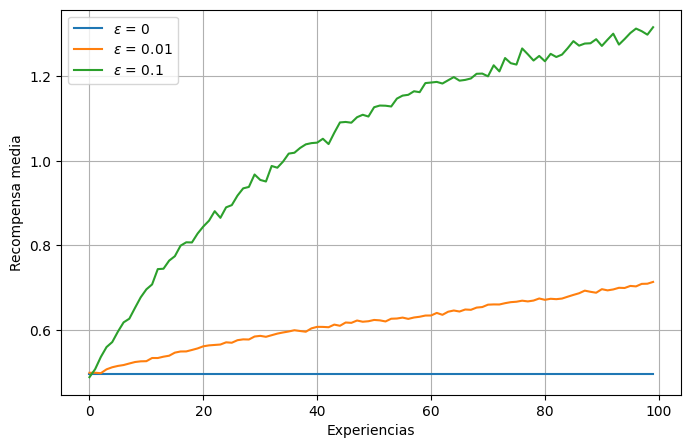

In [8]:
plt.figure(figsize=(8, 5))

# Iterar sobre los diferentes valores de epsilon y sus índices
for i, e in enumerate(epsilons):
    # Graficar la recompensa media para cada epsilon
    plt.plot(recompensas_medias[i], label=f'$\epsilon$ = {e}')
    
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Recompensa media')
plt.show()

Este bloque de código visualiza los resultados del experimento mostrando cómo la recompensa media evoluciona a lo largo de los turnos para diferentes valores de ε. Esto permite comparar el rendimiento de las estrategias ε-greedy con diferentes niveles de exploración y explotación.

Como podemos ver un método greedy se queda encallado con la primera acción buena que encuentra (la cual puede, o no, ser la mejor), mientras que si le dejamos explorar es posible que encuentre nuevas acciones que den como resultado mayores recompensas a largo plazo.

<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\e'
C:\Users\gonza\AppData\Local\Temp\ipykernel_14536\3453740326.py:5: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(acciones_optimas[i], label=f'$\epsilon$ = {e}')


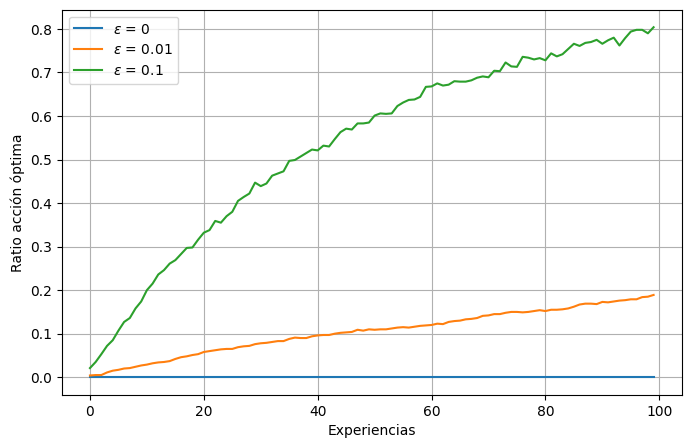

In [9]:
plt.figure(figsize=(8, 5))

for i, e in enumerate(epsilons):
    # Graficar la frecuencia de acciones óptimas para cada epsilon
    plt.plot(acciones_optimas[i], label=f'$\epsilon$ = {e}')

plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Ratio acción óptima')
plt.show()

Este bloque de código visualiza los resultados del experimento mostrando cómo la frecuencia de selección de la acción óptima evoluciona a lo largo de los turnos para diferentes valores de ε. Esto permite comparar el rendimiento de las estrategias ε-greedy en términos de su capacidad para identificar y seleccionar la mejor acción con diferentes niveles de exploración y explotación.

Un valor bajo de $\epsilon$ converge más lento, y en este caso no tiene suficiente tiempo para descubrir la mejor acción. Como hemos comentado brevemente antes, una técnica muy usada consiste en ir reduciendo el valor de $\epsilon$ durante el entrenamiento, así podemos explorar un gran espacio de acciones al principio y enfocarnos en explotar acciones buenas al final. La eficacia de usar un valor de $\epsilon$ u otro dependerás del caso, es un hiperparámetro más a optimizar. En casos con una variancia en las recompensas elevada necesitaremos más exploración, por lo que podemos esperar todavía mejor resultado que sin exploración. Por otro lado, si la variancia fuese 0, un método *greedy* podría encontraría el valor óptimo solo con probar cada acción una vez. Aún así, usar $\epsilon > 0$ suele dar mejor resultado en la mayoría de casos.

## **Implementación incremental**

- Este método también estima el valor de cada acción, pero utiliza un enfoque incremental para actualizar los valores estimados de manera más eficiente.
- En lugar de mantener un valor estimado para cada acción en cada estado, este método utiliza una sola estimación para cada acción y actualiza esa estimación de manera incremental con cada nueva observación.
- La actualización incremental se realiza utilizando una fórmula que considera la diferencia entre la recompensa obtenida y el valor estimado actual, junto con un factor de aprendizaje (también conocido como tasa de aprendizaje) que controla la magnitud del cambio en el valor estimado.
- En resumen, el método de Implementación Incremental actualiza los valores estimados de manera incremental y globalmente para todas las acciones, en lugar de mantener y actualizar valores separados para cada acción en cada estado.


Vamos a ver ahora cómo calcular los valores promedios necesarios para estimar los valores de las acciones de manera más eficiente. En la implementación anterior hemos ido guardando la recompensa obtenida al realizar cada acción, así como el número de veces que una acción se lleva a cabo para calcular el valor de la acción. Sin embargo podemos obtener el mismo resultado con un método incremental.

$$
    Q_{n+1} = Q_n + \alpha [R_n - Q_n]
$$

donde $\alpha \in (0, 1)$ es una contante. Esta fórmula se repite a menudo en el axr, y generalmente la veremos en la siguiente forma

$$
    \text{nuevo valor} \leftarrow \text{viejo valor} + \text{ratio de cambio} \, [\text{valor objetivo}-\text{viejo valor}]
$$

In [10]:

# Configuración del experimento
partidas = 1000  # Número de partidas (episodios)
turnos = 100  # Número de turnos por partida
alpha = 0.5  # Constante de aprendizaje para la actualización incremental
epsilons = [0., 0.01, 0.1]  # Diferentes valores de epsilon para estrategias epsilon-greedy

# Inicializar matrices para guardar las recompensas medias y la frecuencia de acciones óptimas
recompensas_medias = np.zeros((len(epsilons), turnos))
acciones_optimas = np.zeros((len(epsilons), turnos))


# Realizar el experimento para cada partida
for ej in range(partidas):
    # Encontrar la mejor acción (aquella con el valor más alto en q)
    mejor_accion = max(q, key=q.get)
    
    # Iterar sobre los diferentes valores de epsilon
    for i, e in enumerate(epsilons):
        # Inicializar valores Q para las 5 acciones
        Q = {k: 0 for k in range(1, 6)}
        
        # Iterar sobre el número de turnos por partida
        for exp in range(turnos):
            # Elegir acción basada en epsilon
            if np.random.uniform(0, 1) < e:
                # Acción aleatoria
                a = np.random.randint(5) + 1
            else:
                # Acción con mayor valor estimado (explotación)
                maxQ = -100
                for j in range(1, 6):
                    if Q[j] > maxQ:
                        maxQ = Q[j]
                        a = j
            
            # Obtener la recompensa por la acción seleccionada
            recompensa = q[a]
            
            # Actualizar el valor estimado de la acción (Q[a]) usando la fórmula incremental
            Q[a] += alpha * (recompensa - Q[a])
            
            # Acumular la recompensa media
            recompensas_medias[i][exp] += recompensa
            # Contabilizar si la acción seleccionada es la óptima
            acciones_optimas[i][exp] += (a == mejor_accion)

# Promediar las recompensas y las acciones óptimas por el número de partidas
recompensas_medias /= partidas
acciones_optimas /= partidas

<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\e'
C:\Users\gonza\AppData\Local\Temp\ipykernel_14536\1184620638.py:4: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(recompensas_medias[i], label=f'$\epsilon$ = {e}')


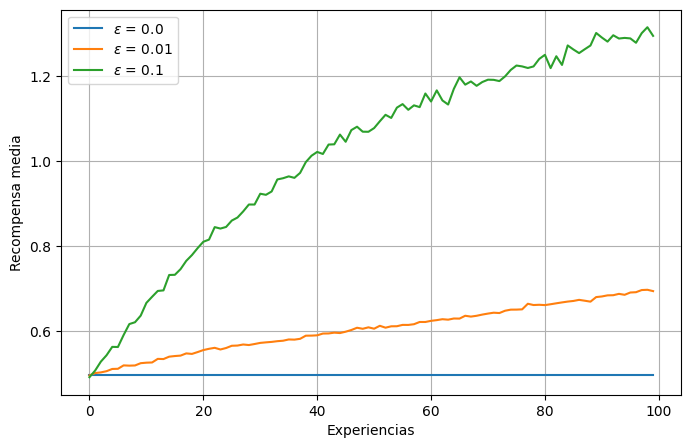

In [11]:
# Graficar los resultados de recompensas medias
plt.figure(figsize=(8, 5))
for i, e in enumerate(epsilons):
    plt.plot(recompensas_medias[i], label=f'$\epsilon$ = {e}')
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Recompensa media')
plt.show()

<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\e'
C:\Users\gonza\AppData\Local\Temp\ipykernel_14536\3222108484.py:4: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(acciones_optimas[i], label=f'$\epsilon$ = {e}')


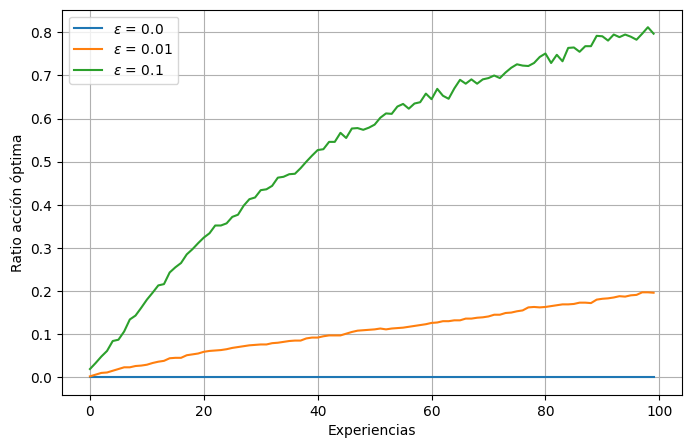

In [12]:
# Graficar los resultados de la frecuencia de acciones óptimas
plt.figure(figsize=(8, 5))
for i, e in enumerate(epsilons):
    plt.plot(acciones_optimas[i], label=f'$\epsilon$ = {e}')
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Ratio acción óptima')
plt.show()

Este código demuestra el balance entre exploración y explotación usando estrategias epsilon-greedy y el método incremental para actualizar los valores estimados de las acciones, cruciales en el aprendizaje por refuerzo.